In [1]:
import re
import sys
import phik
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
assert sys.version_info >= (3, 7, 3)
assert sklearn.__version__ == '0.24.1'

AssertionError: 

In [3]:
# Set default figure size
plt.rcParams["figure.figsize"] = (12,8)

In [4]:
# Define paths to datasets and target/feature information
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'

In [5]:
# Read in data and explicity define datatypes
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
data = pd.read_csv(train, index_col=index, dtype=dtypes)

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Engineering Deck from Cabin number.
 - The first letter of the Cabin number represents the deck so we can extract to new feature.

In [7]:
data['Deck'] = data['Cabin'].apply(lambda x: x[0])

### Engineering Title from Name
 - We can gain from information from the Name feature by extracting the Title.
 - We find that 4 titles dominate - to reduce cardinality we group all others together.

In [8]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())

# Check frequency of each title.
print(data['Title'].value_counts())

# Boolean mask of any title NOT in list
otherTitles = ~data['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])

# Replace non-standard titles with other to reduce cardinality.
data.loc[otherTitles, 'Title'] = 'Other'

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Jonkheer          1
Sir               1
Don               1
Ms                1
Mme               1
Lady              1
Capt              1
the Countess      1
Name: Title, dtype: int64


In [9]:
# Check cardinality of each feature
data.apply(pd.Series.nunique).sort_values(ascending=False)

Name        891
Ticket      681
Fare        248
Cabin       147
Age          88
Deck          8
Parch         7
SibSp         7
Title         5
Embarked      3
Pclass        3
Sex           2
Survived      2
dtype: int64

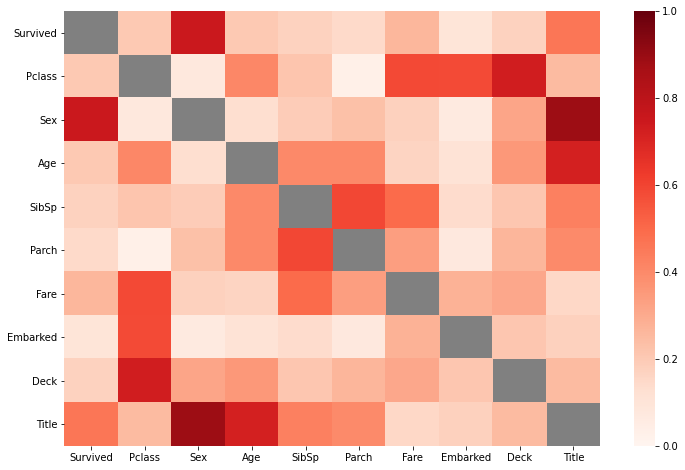

In [10]:
# View phik heatmap - see https://phik.readthedocs.io/en/latest/introduction.html
fig, ax = plt.subplots()
intervalCols = ['Age', 'Fare']
dropCols = ['Name', 'Ticket', 'Cabin']
phik = data.drop(dropCols, axis=1).phik_matrix(interval_cols=intervalCols)
g = sns.heatmap(phik, cmap='Reds', vmin=0, vmax=1, mask=(phik==1), ax=ax)
g.set_facecolor('grey')

## Building a simple Decision Tree model
  - Here we training a decision tree using just Sex, Age and Pclass

In [11]:
# Display estimators as diagrams in Jupyter notebook
set_config(display='diagram')

target = 'Survived'
features = ['Sex', 'Pclass', 'Age']

In [12]:
# Read data and isolate target
X = pd.read_csv(train, index_col=index)
y = X.pop(target)

# Split data from training and testing
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=0, train_size=0.8, test_size=0.2)

In [13]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
141,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C
440,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
818,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C
379,3,"Betros, Mr. Tannous",male,20.0,0,0,2648,4.0125,NaN,C
492,3,"Windelov, Mr. Einar",male,21.0,0,0,SOTON/OQ 3101317,7.2500,NaN,S


### Define preprocessor
 - Create a transformer for the features(s) as required.
 - Here we just perform ordinal encoding on the 'Sex' feature.
   - Categories are explicity provided so that female = 0, male = 1.
 - Impute Pclass and Age with the median values of those features.
 - Any features not defined in the ColumnTransformer are dropped by default.

In [14]:
transformers = [
    ('Sex',    OrdinalEncoder(categories=[['female', 'male']]), ['Sex']),
    ('other',  SimpleImputer(strategy='median'),                ['Pclass', 'Age'])]

preProcessor = ColumnTransformer(transformers=transformers, remainder='drop')

### Check out processed data
  - View processed data as a sanity check, is everything as expected?
  - The custom function below attempts to extract the original feature names from the transformed data.
  - Bit tricky in the case of one-hot encoding etc. and below is not fully tested.

In [15]:
def getFeatureNames(columnTransformer, selector=None):
    """ Extract feature names from column transformer. 
        If transformers are pipelines then encoding step
        should be last step of that pipeline
        Ref: https://github.com/scikit-learn/scikit-learn/issues/12525 
    """
    colNames = np.array([])
    for tupleTransformer in columnTransformer.transformers:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:
            names = tupleTransformer[2]
        # This is for kBinDiscretizers, which have n_bins_ method
        if (isinstance(transformer, KBinsDiscretizer)
                and transformer.encode != 'ordinal'):
            nbins = transformer.n_bins_
            newNames = []
            for col, n in zip(names, nBins):
                newNames = [f'{col}-{i}' for i in range(n)]
            names = newNames
        colNames = np.append(colNames, names)
    if selector is not None:
        colNames = colNames[selector.get_support()]
    return colNames

In [16]:
processedData = pd.DataFrame(
    preProcessor.fit_transform(X_train, y_train), 
    columns=getFeatureNames(preProcessor))
processedData.head()

,Sex,Pclass,Age
0,0.0,3.0,29.0
1,1.0,2.0,31.0
2,1.0,2.0,31.0
3,1.0,3.0,20.0
4,1.0,3.0,21.0


### Build pipeline and train model

In [17]:
# Combine processor and modelling steps into a Pipeline object
model = Pipeline(steps=[
    ('preProcess', preProcessor),
    ('estimator',  DecisionTreeClassifier(max_depth=3)),
])

In [18]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preProcess',
                 ColumnTransformer(transformers=[('Sex',
                                                  OrdinalEncoder(categories=[['female',
                                                                              'male']]),
                                                  ['Sex']),
                                                 ('other',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age'])])),
                ('estimator', DecisionTreeClassifier(max_depth=3))])

In [19]:
# Check score against unseen data
model.score(X_valid, y_valid)

0.7988826815642458

### Visualise decision tree
  - Model predicts...
    - All females suvive **except** children under 2.5 in class 1 or 2 OR adults over 38.5 in class 3.
    - All males die **except** children under 14 in class 1 or 2

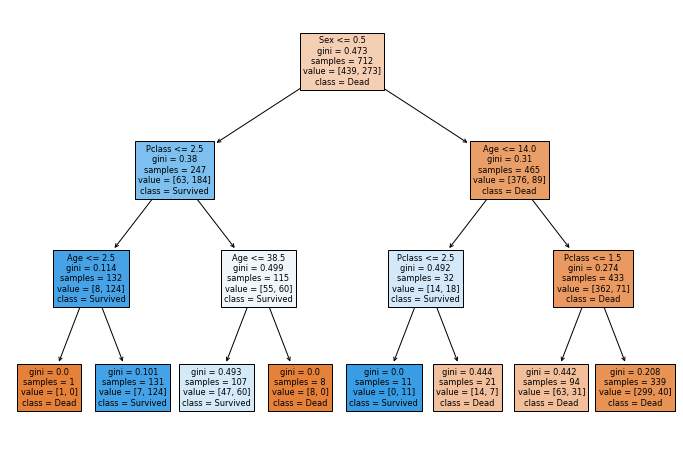

In [20]:
tree = model.named_steps['estimator'] # Extract estimator from Pipeline object
fig, ax = plt.subplots()
_ = plot_tree(tree, feature_names=features, class_names=['Dead', 'Survived'], filled=True, ax=ax)

In [22]:
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
correct = pd.read_csv('submissionTrue.csv')['Survived']
myBest = pd.read_csv('submissionBest.csv')['Survived']
currentPredict = model.predict(X_test)
actualScore = (correct == currentPredict).sum() / len(correct)
print(actualScore)

0.7607655502392344
